# Sheet 6

In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline
plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (12 / 2.54, 6 / 2.54)
plt.rcParams['figure.constrained_layout.use'] = True

## Autoencoders: theory and practice

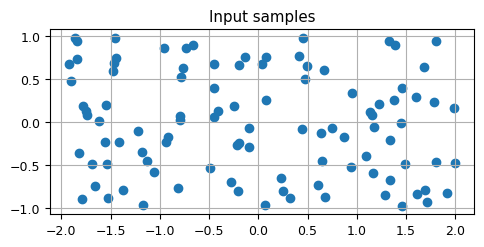

In [2]:
# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [3]:
# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


### (a)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_channels, latent_dim=1, input_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        # define the encoder and decoder.
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # add layers for encoder.
        for i, dim in enumerate([*hidden_channels, latent_dim]):
            prev = input_dim if i == 0 else hidden_channels[i-1]
            self.encoder.append(nn.Linear(prev, dim))
            if i != len(hidden_channels):
                self.encoder.append(nn.ReLU())

        # add layers for decoder.
        for i, dim in enumerate([*hidden_channels[::-1], input_dim]):
            prev = latent_dim if i == 0 else hidden_channels[::-1][i-1]
            self.decoder.append(nn.Linear(prev, dim))
            if i != len(hidden_channels):
                self.decoder.append(nn.ReLU())
   
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

In [5]:
autoencoder_module_small = AutoencoderModule(hidden_channels=(20, 10))
autoencoder_module_big = AutoencoderModule(hidden_channels=(50, 50))
autoencoder_module_pca = AutoencoderModule(hidden_channels=())

print("Small model:", autoencoder_module_small)
print("Big model:",   autoencoder_module_big)
print("PCA model:",   autoencoder_module_pca)

Small model: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)
Big model: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (

Using ReLU functions to introduce some simple non-linearity. The output layer is not run through that function, so that it can reconstruct inputs with negative values. The latent layer is also not run through the activation function so that we can make use of its full structure.

### (b)

In [ ]:
# start the training using a PyTorch Lightning Trainer
for module in ["small", "big", "pca"]:
    module = locals()[f"autoencoder_module_{module}"]
    trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False, enable_model_summary=False)
    trainer.fit(module, data_loader)

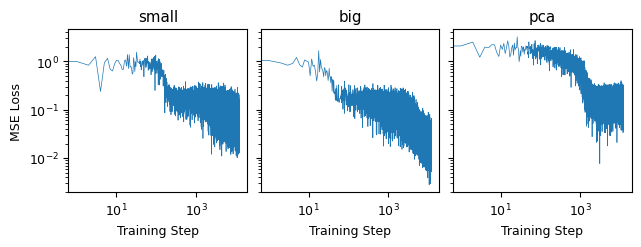

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54), sharey=True)

for ax, module in zip(axs, ["small", "big", "pca"]):
    ax.set_title(module)
    module = locals()[f"autoencoder_module_{module}"]
    ax.plot(module.loss_curve, lw=0.5)

for ax in axs:
    ax.set_xlabel("Training Step")
    ax.set_ylabel("MSE Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.label_outer()

We have 100 samples, so with a batch size of 8, we get 12 batches (and drop the remaining 4 samples). In each of the 1000 epochs, we thus train with 12 batches, totalling in 12 000 training steps.

The large autoencoder model reaches the smallest loss value, followed by the small autoencoder. As expected, the reconstruction of the PCA model is the least accurate. The big model looks like it could improve even more with more training steps, the small one maybe as well.

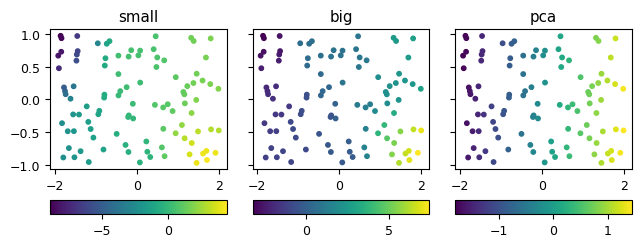

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(16 / 2.54, 6 / 2.54), sharey="row",
                        gridspec_kw={"height_ratios": [1, 0.1], "wspace": 0.1})

for col, module in zip(axs.T, ["small", "big", "pca"]):
    col[0].set_title(module)
    module = locals()[f"autoencoder_module_{module}"]

    # encode data and use the latent space values as colors.
    encoded_data = module.autoencoder.encoder(data).detach()
    img = col[0].scatter(*data.T, s=10, c=encoded_data[:, 0])
    fig.colorbar(img, cax=col[1], orientation="horizontal")

As expected, PCA finds the axis of largest variance. As the range in $x$-direction is larger than in $y$-direction, the PCA-axis also mostly aligns with a rescaled $x$-axis.

In the small AE, the negative values of the embedded component start at the top left and then increase when moving somewhat diagonally to the the bottom right. In the large AE, the mapping seems a bit more complex.

We can also see that the range of the embedded component's value differs a bit between the three autoencoders, so that it's not always centered at 0.

### (c)

#### (i) Random Initialization

As the PCA model is purely linear, I would expect a line in a random direction. The curves of the other two autoencoders would then be made up of multiple line segments, each going in random directions, so it would like a random walk.

#### (ii) Trained Models

The curve should follow the colors in the plot above. For PCA, there should be a line showing the principal axis (approx. in $x$-direction). The curves of the small AE would then go approximately diagonally from the top left to the bottom right, and the one of the big AE would have a few more kinks inbetween to follow the more complex mapping.

### (d)

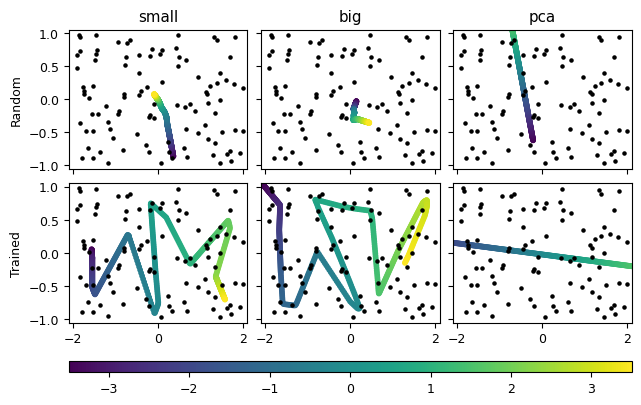

In [10]:
latent_interval = torch.linspace(-3.5, 3.5, 500).reshape(-1, 1)

fig, axs = plt.subplots(2, 3, figsize=(16 / 2.54, 10 / 2.54), sharey=True)

for (ax1, ax2), module in zip(axs.T, ["small", "big", "pca"]):
    ax1.set_title(module)
    module = locals()[f"autoencoder_module_{module}"]

    # decode latent space values with randomly initialized model.
    random_model = Autoencoder(hidden_channels=module.autoencoder.hidden_channels)
    random_data = random_model.decoder(latent_interval).detach()
    im = ax1.scatter(*random_data.T, s=10, c=latent_interval, rasterized=True)
    ax1.scatter(data[:, 0], data[:, 1], s=5, c="k")

    # decode latent space values with trained model.
    decoded_data = module.autoencoder.decoder(latent_interval).detach()
    im = ax2.scatter(*decoded_data.T, s=10, c=latent_interval, rasterized=True)
    ax2.scatter(data[:, 0], data[:, 1], s=5, c="k")

    ax1.set_ylabel("Random")
    ax2.set_ylabel("Trained")

    for ax in (ax1, ax2):
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-1.05, 1.05)
        ax.label_outer()

fig.colorbar(im, ax=axs, orientation="horizontal", fraction=0.07, aspect=50)
plt.show()

For the randomly initialized models, the PCA curve looks as expected. The other two curves are more packed together and have fewer direction changes than expected.

For the trained models, the PCA curve also looks as expected. The curve of the small model, however, is not diagonal at all but already follows quite a complex path. It also doesn't start at the top left corner, because the range $[-3.5, 3.5]$ of the embedded component doesn't start at its minimum.
The curve of the large model looks very similar to the one of the small model, but has an even higher number of kinks. This increased variability is what allows the loss value to be even smaller in that model.

### (e)

As we can already see in (d) that a larger number of parameters leads to the the autoencoder tracing the random data more precisely, I assume that for a finite dataset, a large enough network will be able to trace a path going through all data points one by one. Then, each point can be associated with a position on the curve, allowing for a perfect reconstruction. As that autoencoder is then perfectly fit to the training data, it will perform poorly on data with points outside the curve.

### (f)

When training only the encoder to a pretrained decoder, the model will try to learn how to map the input points to the path seen in (d). Ideally, the resulting network will have the same weights as one where both parts were trained at once.

### (g)

In [93]:
# copy the weights of the big model to a new model.
autoencoder_module_trained = AutoencoderModule(hidden_channels=autoencoder_module_big.autoencoder.hidden_channels)
autoencoder_module_trained.load_state_dict(autoencoder_module_big.state_dict())

<All keys matched successfully>

In [94]:
# reset encoder parameters.
for layer in autoencoder_module_trained.autoencoder.encoder:
    if hasattr(layer, "reset_parameters"):
        layer.reset_parameters()

# keep decoder parameters.
for param in autoencoder_module_trained.autoencoder.decoder.parameters():
    param.requires_grad = False

In [ ]:
trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False, enable_model_summary=False)
trainer.fit(autoencoder_module_trained, data_loader)

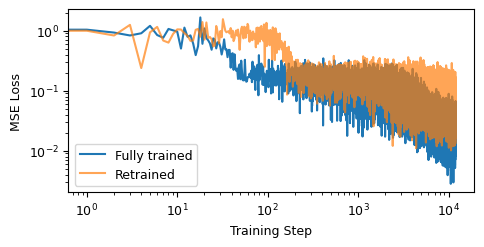

In [96]:
plt.plot(autoencoder_module_big.loss_curve, label="Fully trained")
plt.plot(autoencoder_module_small.loss_curve, alpha=0.7, label="Retrained")
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="lower left")
plt.show()

The model with the retrained encoder consistently performs worse while training.

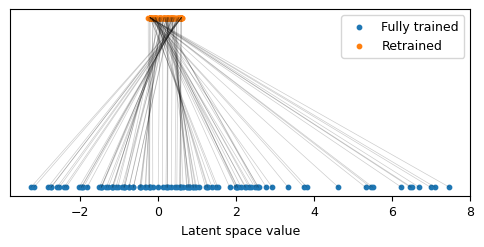

In [102]:
encoded_prev = autoencoder_module_big.autoencoder.encoder(data).detach()
encoded_new = autoencoder_module_trained.autoencoder.encoder(data).detach()

plt.scatter(encoded_prev, torch.zeros_like(encoded_prev), s=10, label="Fully trained")
plt.scatter(encoded_new, torch.ones_like(encoded_new), s=10, label="Retrained")

for prev, new in zip(encoded_prev[:, 0], encoded_new[:, 0]):
    plt.plot([prev, new], [0, 1], lw=0.5, c="k", alpha=0.2)

plt.xlabel("Latent space value")
plt.yticks([])
plt.legend()
plt.show()

The network was not able to learn the correct mapping to the latent space, which is expected by the decoder. Instead, the resulting mapping is completely different. While it may at first look like a rescaling with a factor of about $-10$, that is also not the case. This explains the consistently higher loss, though it still comes as a surprise that the loss still comes down significantly with training.

### (h)

In [103]:
class SGDModule(AutoencoderModule):
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

Normal gradient descent is just stochastic gradient descent, but with a single batch containing all the data at once.

In [25]:
data_loader_single_batch = DataLoader(dataset, batch_size=num_samples, shuffle=True)

autoencoder_module_gd = SGDModule(hidden_channels=autoencoder_module_big.autoencoder.hidden_channels)
autoencoder_module_sgd = SGDModule(hidden_channels=autoencoder_module_big.autoencoder.hidden_channels)

trainer_gd = pl.Trainer(max_epochs=1000, enable_checkpointing=False, enable_model_summary=False)
trainer_sgd = pl.Trainer(max_epochs=1000, enable_checkpointing=False, enable_model_summary=False)

trainer_gd.fit(autoencoder_module_gd, data_loader_single_batch)
trainer_sgd.fit(autoencoder_module_sgd, data_loader)

In gradient descent, we have 1000 training steps, each with all 100 samples. In stochastic gradient descent, we have 12 000 training steps due to the batching, with each batch containing 8 steps.

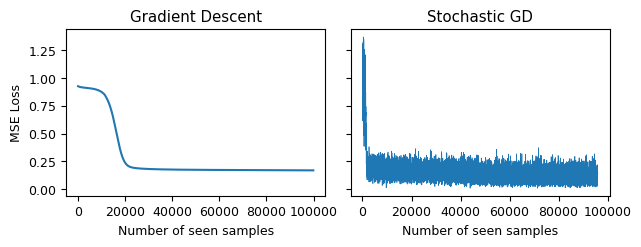

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16 / 2.54, 6 / 2.54), sharey=True)

axs[0].set_title("Gradient Descent")
axs[1].set_title("Stochastic GD")
axs[0].plot(100 * torch.arange(1000), autoencoder_module_gd.loss_curve)
axs[1].plot(8 * torch.arange(12000), autoencoder_module_sgd.loss_curve, lw=0.5)

for ax in axs:
    ax.set_xlabel("Number of seen samples")
    ax.set_ylabel("MSE Loss")
    ax.label_outer()

We can clearly see how in SGD, the loss decreases much faster, but with a lot more noise.